# Mock Data Pipeline

`scippr` requires inputs in the form of catalogs $\{p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{m}_{n}, \underline{\phi}^{*}, \vec{\theta}^{*})\}_{N}$ of interim posteriors.

In [ ]:
import daft
import astropy.cosmology as cosmology

import numpy as np
import bisect
import sys
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)

colors = 'rbgcymk'

`scippr` is based on a probabilistic graphical model, illustrated below.  The model has two types of observables, supernova lightcurves $\underline{\ell}_{n}$ and host galaxy photometry $\vec{m}_{n}$.  The latent variables of supernova type $t_{n}$, redshift $z_{n}$, and distance modulus $\mu_{n}$ are parameters over which we will marginalize, without ever directly inferring them, and while all three of them influence $\underline{\ell}_{n}$, only $z_{n}$ affects $\vec{m}_{n}$.  The hyperparameters we would like to estimate are the redshift-dependent supernova type proportions $\underline{\phi}$ that determine $t_{n}$ and $z_{n}$ and the cosmological parameters $\vec{\theta}$ that relate $z_{n}$ to $\mu_{n}$.  Thus far, the model makes the following assumptions that will be addressed in a future revision:

* There is no correlation between the host galaxy photometry and either the supernova type or the lightcurve.
* The supernova selection function does not affect the inference of the cosmological parameters, i.e. the observed supernovae are perfectly representative of the set of all supernovae in the universe.

In [ ]:
#initialize the PGM
pgm = daft.PGM([5, 6], origin=[0, 0])

#desired hyperparameters
pgm.add_node(daft.Node("cosmology", r"$\vec{\theta}$", 1., 5.5))
pgm.add_node(daft.Node("dist", r"$\underline{\phi}$", 2.5, 5.5))
#pgm.add_node(daft.Node("rates", r"$\vec{R}$", 3., 5.5, fixed=True))

#latent variables/parameters
pgm.add_node(daft.Node("distance", r"$\mu_{n}$", 1., 4.))
pgm.add_node(daft.Node("redshift", r"$z_{n}$", 2., 4.5))
pgm.add_node(daft.Node("type", r"$t_{n}$", 3., 4.5))

#data
pgm.add_node(daft.Node("lightcurve", r"$\underline{\ell}_{n}$", 1.5, 3., observed=True))
pgm.add_node(daft.Node("photometry", r"$\vec{m}_{n}$", 3., 3., observed=True))

# Add in the edges.
pgm.add_edge("dist", "type")
pgm.add_edge("cosmology", "distance")
pgm.add_edge("dist", "redshift")
pgm.add_edge("redshift", "distance")
#pgm.add_edge("distance", "photometry")
pgm.add_edge("distance", "lightcurve")
pgm.add_edge("redshift", "photometry")
pgm.add_edge("redshift", "lightcurve")
pgm.add_edge("type", "lightcurve")

# plates
pgm.add_plate(daft.Plate([0.5, 2., 3., 3.], label=r"$n = 1, \cdots, N$"))

# Render and save.
pgm.render()
pgm.figure.show()

To simulate mock data for `scippr`, there are three main steps.

1. Choose true values for the hyperparameters, which we would like to recover from our inference, and the parameters, over which we intend to marginalize.
2. Create likelihoods based on a model for how they are derived from observations.
3. Make interim posteriors by assuming interim priors.

## Choosing true hyperparameters and parameters

[the true redshift-dependent type rate distribution, with plot of three functions] 

In [ ]:
types = ['Ia', 'Ibc', 'II']
n_types = len(types)
# making up the type fractions, will replace this with data soon!
frac_types = np.array([0.2, 0.3, 0.5])
assert np.isclose(np.sum(frac_types), 1.)

# this binning is arbitrary!
n_zs = 20
min_z = 0.5
max_z = 2.
z_bins = np.linspace(min_z, max_z, num=n_zs + 1, endpoint=True)
z_difs = z_bins[1:] - z_bins[:-1]
z_dif = np.mean(z_difs)
z_range = max_z - min_z
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.

# it actually doesn't make sense to bin this up at this stage -- the true n_t(z) can be continuous
n_of_z = np.zeros((n_types, n_zs))
n_of_z[0] += sps.norm(loc = 1.5, scale = 0.5).pdf(z_mids)
n_of_z[1] += sps.norm(loc = 1., scale = 0.5).pdf(z_mids)
n_of_z[2] += sps.norm(loc = 0.5, scale = 0.5).pdf(z_mids)
n_of_z /= np.sum(n_of_z * z_difs[np.newaxis, :], axis=1)[:, np.newaxis]

true_n_of_z = frac_types[:, np.newaxis] * np.array(n_of_z)# / z_range
true_n_of_z /= np.sum(true_n_of_z * z_difs[np.newaxis, :])
assert np.isclose(np.sum(true_n_of_z * z_difs[np.newaxis, :]), 1.)

for t in range(n_types):
    plt.plot(z_mids, true_n_of_z[t], color=colors[t], label=types[t])
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend()

[samples of t, z from the true redshift-dependent type rate distribution, with histograms]

In [ ]:
# I'm sampling from a piecewise constant function, but it should actually be continuous at this stage
def sample_discrete(dist, N):
    out_info = []
    norm_dist = dist * z_difs[np.newaxis, :]
    assert np.isclose(np.sum(norm_dist), 1.)
    dist_shape = np.shape(norm_dist)
    flat_dist = norm_dist.flatten()
    cdf = np.cumsum(flat_dist)
    for n in range(N):
        each = {}
        r = np.random.random()
        k = bisect.bisect(cdf, r)
        (t_ind, z_ind) = np.unravel_index(k, dist_shape)
        each['t'] = types[t_ind]
        each['z'] = np.random.uniform(low=z_bins[z_ind], high=z_bins[z_ind + 1])
        out_info.append(each)
    return out_info

n_sne = 50

true_params = sample_discrete(true_n_of_z, n_sne)

to_plot = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
for t in range(n_types):
    plt.plot(z_mids, true_n_of_z[t]*3., color=colors[t], label=types[t])
    plt.hist(to_plot[t], color=colors[t], alpha=1./3., label=types[t], normed=True)
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend()

[the true cosmology, true mu for each t, z, plot hubble diagram]

In [ ]:
# Planck
true_H0 = 67.9
true_Om0 = 1. - 0.693
true_hyperparams = np.array([true_H0, true_Om0])
n_hyperparams = len(true_hyperparams)
true_cosmo = cosmology.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)

for n in range(n_sne):
    true_params[n]['mu'] = true_cosmo.distmod(true_params[n]['z']).value
    
to_plot_x = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
to_plot_y = [[d['mu'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
for t in range(n_types):
    plt.scatter(to_plot_x[t], to_plot_y[t], color=colors[t], label=types[t])
plt.plot(z_mids, [true_cosmo.distmod(z).value for z in z_mids], color='k')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend()
plt.title(r'$H_{0}='+str(true_H0)+r', \Omega_{m,0}='+str(true_Om0)+r'$')

## Creating likelihoods

[the confusion matrix]

In [ ]:
# will need to take this from data of some kind, arbitrary for now
conf_matrix = 0.25 + 0.25 * np.eye(3)
assert np.isclose(np.sum(conf_matrix, axis=1).all(), frac_types.all())

[set up mu parametrization]

In [ ]:
# want this to be agnostic about true cosmology
n_mus = n_zs
min_mu, max_mu = min([s['mu'] for s in true_params]) - 0.5, max([s['mu'] for s in true_params]) + 0.5
mu_bins = np.linspace(min_mu, max_mu, num=n_mus + 1, endpoint=True)
mu_difs = mu_bins[1:] - mu_bins[:-1]
mu_dif = np.mean(mu_difs)
mu_range = np.max(mu_bins) - np.min(mu_bins)
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.

z_mu_grid = np.array([[(z, mu) for mu in mu_mids] for z in z_mids])
cake_shape = np.shape(z_mu_grid)

[the functions taking true type, true z, and true mu returning p(type, z, mu | hat(t))]

In [ ]:
# must set nuisance parameters inherent in process of producing interim posteriors from lightcurves
Ia_Ia_var = np.array([0.01, 0.05])
Ibc_Ia_delta = 1.
Ibc_Ia_var = np.array([0.01, 0.01])
II_Ia_delta = np.mean(mu_mids)
II_Ia_var = np.array([0.05, 0.1])

# definitely needs more work on what (z, mu) distributions are expected when lightcurves are fit with wrong templates
# just made it flat for now

def fit_Ia(z, mu):
    cake = np.zeros((n_types, n_zs, n_mus))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu]), cov = Ia_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ia_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    cake[1] = np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake *= conf_matrix[:, 0, np.newaxis, np.newaxis]
    return cake
    
def fit_Ibc(z, mu):
    cake = np.zeros((n_types, n_zs, n_mus))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu - Ibc_Ia_delta]), cov = Ibc_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ibc_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    cake[1] = np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake *= conf_matrix[:, 1, np.newaxis, np.newaxis]
    return cake
    
def fit_II(z, mu):
    cake = np.zeros((n_types, n_zs, n_mus))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, II_Ia_delta]), cov = II_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = II_Ia_var * np.eye(2))
    cake[0] = cake_Ia.pdf(z_mu_grid.reshape(-1, cake_shape[-1])).reshape(cake_shape[:-1])
    cake[1] = np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake[2] = np.ones(cake_shape[:-1]) / np.prod(cake_shape[:-1])
    cake *= conf_matrix[:, 2, np.newaxis, np.newaxis]
    return cake
    
def fit_any(true_vals):
    if true_vals['t'] == 'Ia':
        cake = fit_Ia(true_vals['z'], true_vals['mu'])
    if true_vals['t'] == 'Ibc':
        cake = fit_Ibc(true_vals['z'], true_vals['mu'])
    if true_vals['t'] == 'II':
        cake = fit_II(true_vals['z'], true_vals['mu'])
    return cake

def fit_all(catalog):
    dessert = []
    for true_vals in catalog:
        dessert.append(fit_any(true_vals))
    return np.array(dessert)

sheet_cake = fit_all(true_params)

# happily, these look like what we see in contaminated hubble diagrams!
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_mids, mu_mids, sheet_cake[s][t].T, cmap='viridis', vmin = 0., vmax = 3.)
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='k')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])

[make p(z)s]

In [ ]:
# very simple p(z) model, simple gaussians
pzs = []
for s in range(n_sne):
    dist = sps.norm(loc = true_params[s]['z'], scale = 0.03)
    pz_mean = dist.rvs()
    pz = sps.norm(loc = pz_mean, scale = 0.03).pdf(z_mids)
    pzs.append(pz)
pzs = np.array(pzs)

for s in range(n_sne)[:len(colors)]:
    plt.plot(z_mids, pzs[s], color=colors[s])
    plt.vlines(true_params[s]['z'], 0., 15., color=colors[s])
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.title(r'host galaxy $p(z)$ distributions')

[multiply likelihood components]

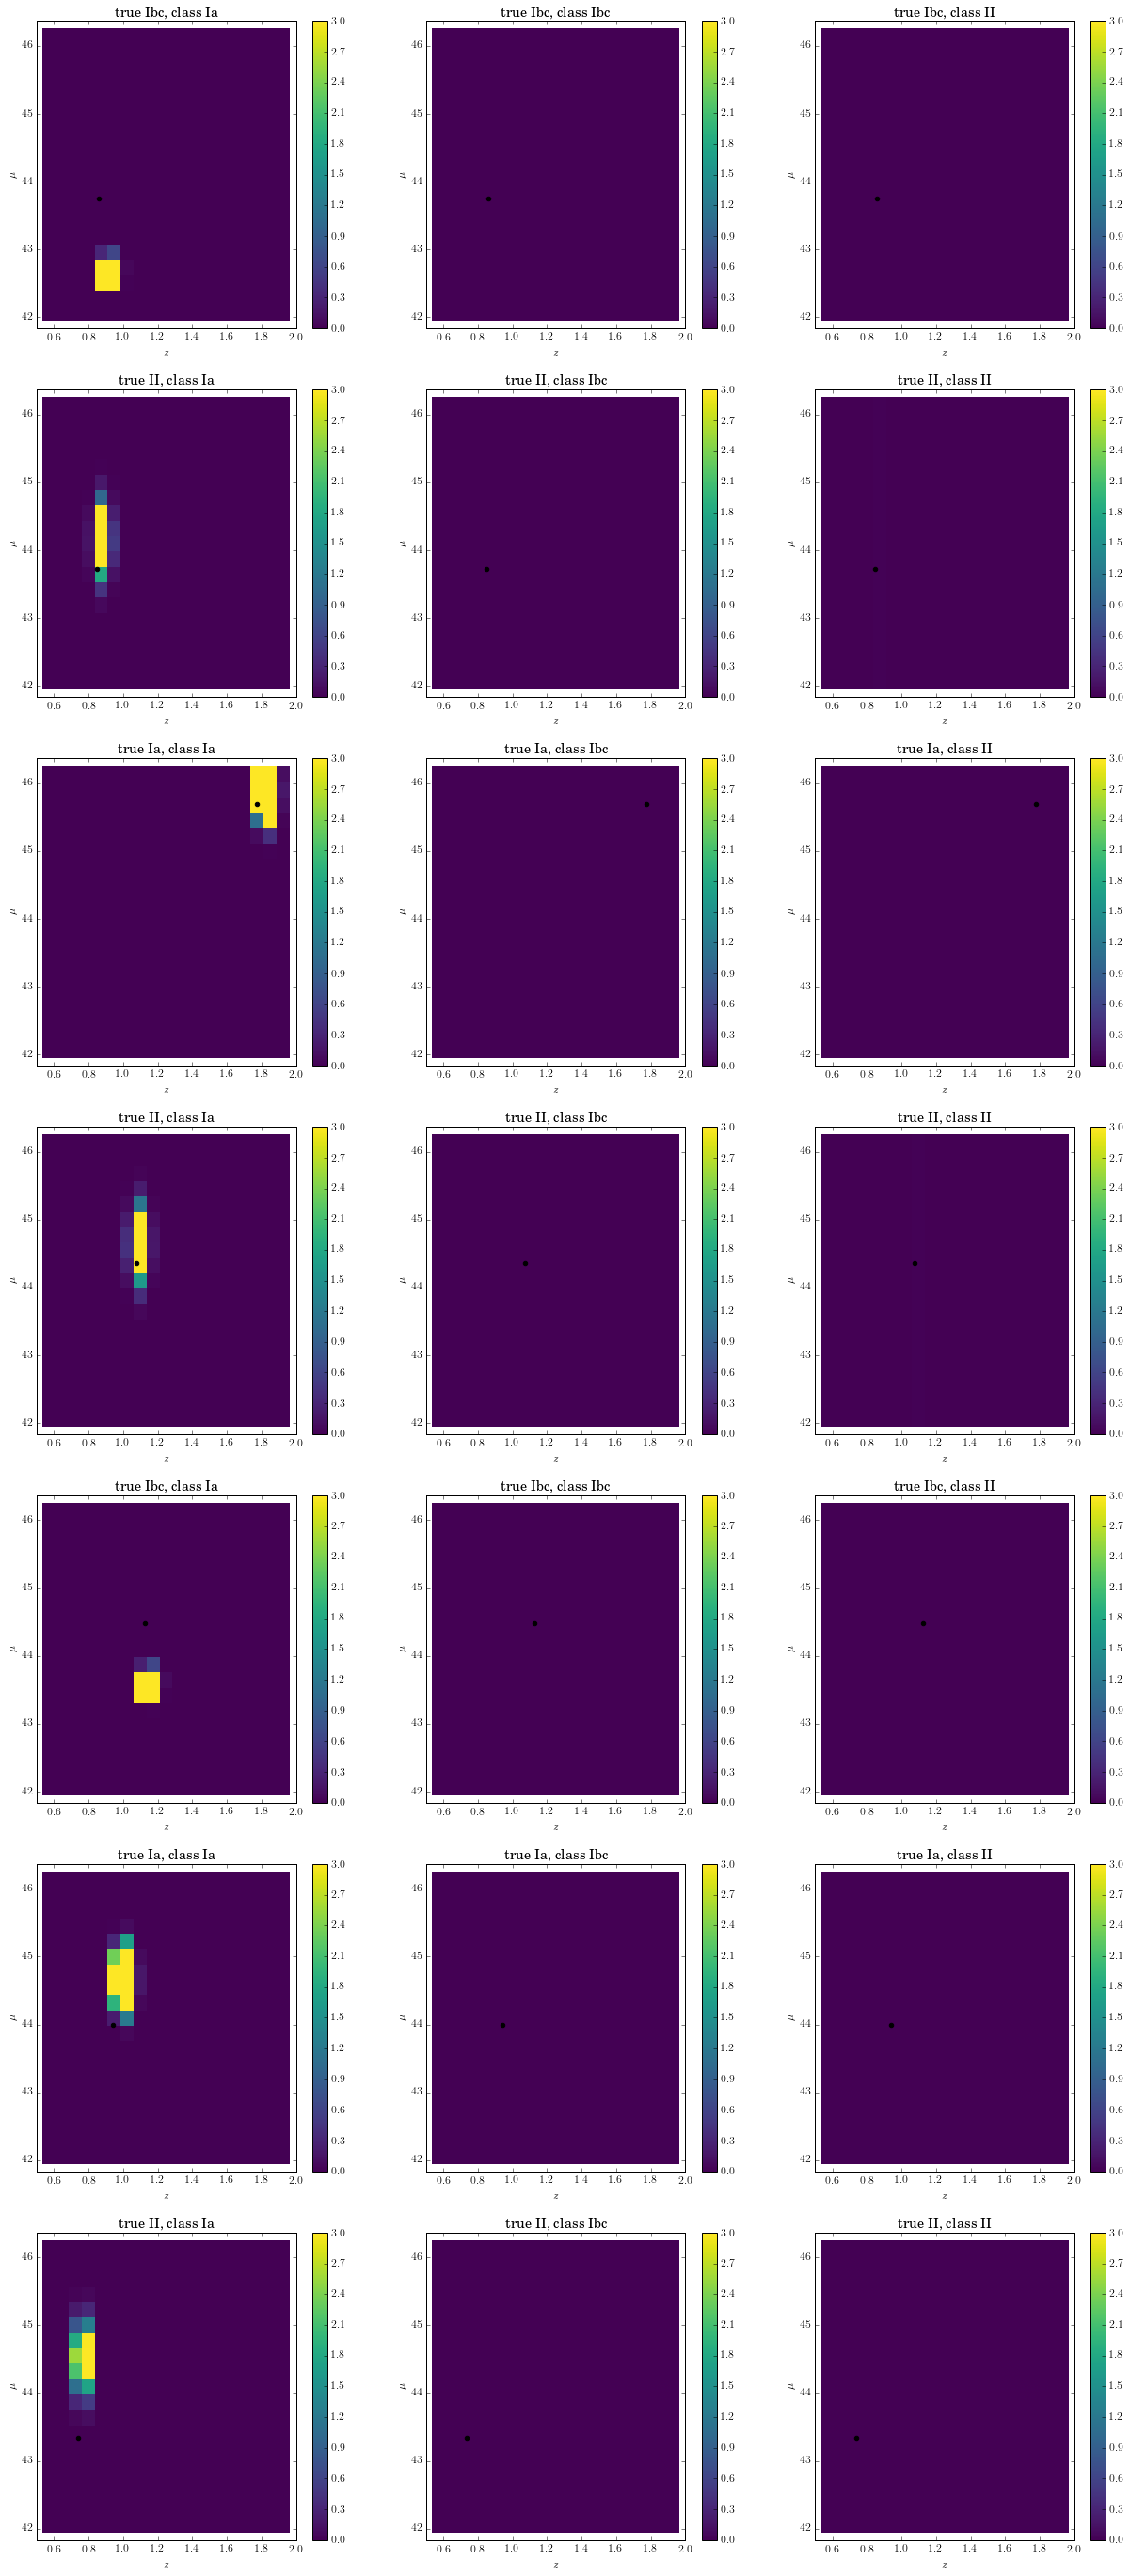

In [34]:
# these don't have to be normalized
likelihoods = sheet_cake * pzs[:, np.newaxis, :, np.newaxis]

# look at how much narrower they are! this should be visible in all types, but the color scaling is bad for Ibc & II
fig = plt.figure(figsize=(n_types*len(colors), n_sne*len(colors)))
p = 0
for s in range(n_sne)[:len(colors)]:
    for t in range(n_types):
        p += 1
        plt.subplot(n_sne, n_types, p)
        plt.pcolormesh(z_mids, mu_mids, likelihoods[s][t].T, cmap='viridis', vmin = 0., vmax = 3.)
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='k')
        plt.title('true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])

## Making interim posteriors

[interim priors to make interim posteriors]

In [ ]:
# flat prior on redshift-dependent SNe proportions
interim_n_of_z = np.ones((n_types, n_zs))
interim_n_of_z /= np.sum(interim_n_of_z * z_difs[np.newaxis, :])
assert np.isclose(np.sum(interim_n_of_z * z_difs[np.newaxis, :]), 1.)

# WMAP, which 10 * errors so
interim_H0 = 70.0
delta_H0 = 2.2 * 10.
interim_Om0 = 1. - 0.721
delta_Om0 = 0.025 * 10.
interim_hyperparams = np.array([interim_H0, interim_Om0])
interim_hyperparam_vars = np.array([delta_H0, delta_Om0]) * np.eye(n_hyperparams)
interim_dist = sps.multivariate_normal(mean = interim_hyperparams, cov = interim_hyperparam_vars)
interim_cosmo = cosmology.FlatLambdaCDM(H0=interim_hyperparams[0], Om0=interim_hyperparams[1])

def inverter(z, mu):
    def cosmo_helper(hyperparams):
        return np.array([abs(cosmology.FlatLambdaCDM(H0=hyperparams[0], Om0=hyperparams[1]).distmod(z).value - mu)])
    solved_cosmo = spo.minimize(cosmo_helper, interim_hyperparams, method="Nelder-Mead", options={"maxfev": 1e5, "maxiter":1e5})
    prob = interim_dist.pdf(solved_cosmo.x)
    return max(prob, sys.float_info.epsilon)

interim_sheet = np.zeros((n_zs, n_mus))
for z in range(n_zs):
    for mu in range(n_mus):
        prob = inverter(z_mids[z], mu_mids[mu])
        interim_sheet[z][mu] = prob
interim_prior = interim_n_of_z[:, np.newaxis] * interim_sheet[np.newaxis, :]
interim_prior /= np.sum(interim_prior * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
assert np.isclose(np.sum(interim_prior * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

plt.pcolormesh(z_mids, mu_mids, interim_sheet.T, cmap='viridis')
plt.plot(z_mids, [true_cosmo.distmod(z).value for z in z_mids], color='k')
plt.plot(z_mids, [interim_cosmo.distmod(z).value for z in z_mids], color='r')
plt.title('interim prior distribution')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.colorbar()

[multiply likelihoods and interim prior]

In [ ]:
# this must be normalized
interim_posteriors = likelihoods * interim_prior[np.newaxis, :]
interim_posteriors /= np.sum(interim_posteriors * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
assert np.isclose(np.sum(interim_posteriors * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

## Preparing output for `scippr` inference

[write data to file]

In [ ]:
# write true hyperparameters just to check

# write axes
# write interim prior
# write interim posteriors